In [1]:
using DrWatson
@quickactivate "WiFi-Imager"
includet(srcdir("funcs.jl"))
using CairoMakie

In [2]:
includet(srcdir("makie_theme.jl"))

In [3]:
includet(projectdir("config", "maxwell_vs_ray.jl"))
configs_list = dict_list(configs)
length(configs_list)

5

In [4]:
using SpecialFunctions
function get_Es(config_now)
    @unpack freq, grids_y, grids_x, dis_target_rx, doi_size_x, doi_size_y, tx_num, rx_num, dis_antenna, tag_size_x, tx_x = config_now
    tag_size_y_all = collect((0.5:0.5:15) .* 0.06)
    Es_res = zeros(size(tag_size_y_all, 1))
    Es_ray_res = zeros(size(tag_size_y_all, 1))
    for tx_index in axes(tag_size_y_all, 1)
        tag_size_y = tag_size_y_all[tx_index]
        Tx_pos = [tx_x 0.0]'
        rxs_pos_x = repeat([dis_target_rx], rx_num)'
        rxs_pos_y = ((collect(1:rx_num) .- (rx_num + 1) / 2) .* dis_antenna)'
        Rx_pos = [rxs_pos_x; rxs_pos_y]
        parameters = ConstantParameter(freq=freq,
            doi_size_x=doi_size_x,
            doi_size_y=doi_size_y,
            grid_number_x=grids_x,
            grid_number_y=grids_y,
            txs_pos=Tx_pos,
            rxs_pos=Rx_pos)
        epslion = 10
        Ei_in_rxs_all, Ei_in_domain_all, GS_all, GDZ_all = get_shared_variables_born(
            [parameters])
        regeangle_pos = [[-tag_size_x / 2, tag_size_y / 2, tag_size_x / 2, tag_size_y / 2, tag_size_x / 2, -tag_size_y / 2, -tag_size_x / 2, -tag_size_y / 2,]]
        scatterer = get_scatterer(regeangle_pos, [epslion], parameters)
        Ei_in_rxs = Ei_in_rxs_all[1]
        Ei_in_domain = Ei_in_domain_all[1]
        GS = GS_all[1]
        GDZ = GDZ_all[1]
        scatter_centroid_xs, scatter_centroid_ys, object_grid_indices = find_grids_with_object(
            parameters,
            scatterer)
        impedance_in_domain = get_impedance_in_domain(parameters,
            vec(scatterer)[object_grid_indices],
            scatter_centroid_xs,
            scatter_centroid_ys)
        current = get_induced_current(parameters,
            impedance_in_domain,
            Ei_in_domain[object_grid_indices, :],
            object_grid_indices;)
        Es = (get_scattered_field(parameters, current, GS;))[2, :]

        dis_tx_rx = (dis_target_rx - tx_x) - tag_size_x
        er = real(epslion)
        ei = imag(epslion)
        # n = sqrt(0.5*(er*(1+sqrt(1+(wi/er)^2))))
        att = parameters.λ / (2 * pi) * sqrt(2 / (er * (-1 + sqrt(1 + (ei / er)^2))))
        Es_ray = 1 / dis_tx_rx * exp(-tag_size_x / att)
        Es_res[tx_index] = abs(Es[1])
        Es_ray_res[tx_index] = abs(Es_ray)
    end
    return Es_res, Es_ray_res
end

get_Es (generic function with 1 method)

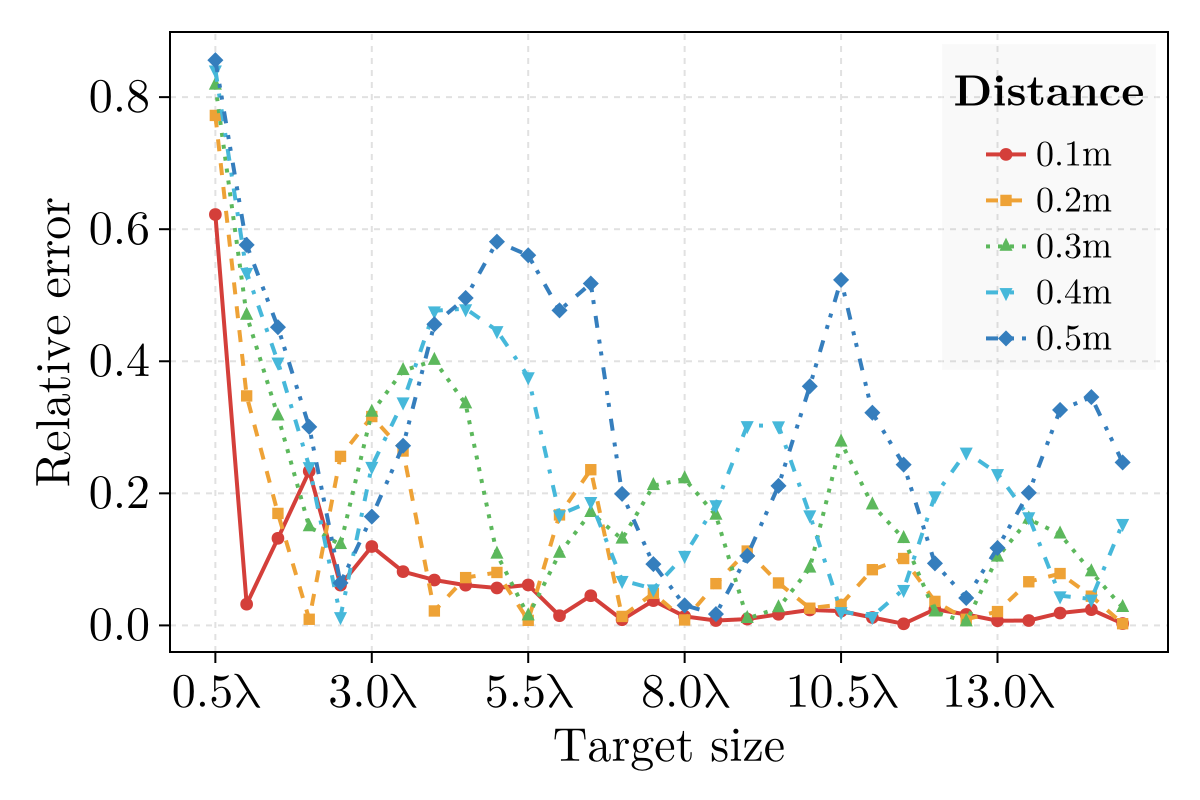

In [13]:
CairoMakie.activate!(type="svg")

xs = collect((0.5:0.5:15) .* 0.06)
fig = Figure(size=(600, 400), rasterize=8)
ax = Axis(fig[1, 1], xlabel="Target size", ylabel="Relative error", xticks=(1:5:30, ["$(round(xs[i]/0.06,digits=1))" * "λ" for i in 1:5:30]))
for ii in 1:length(configs_list)
    Es_now, Es_ray_now = get_Es(configs_list[ii])
    scatterlines!(ax, abs.(Es_now .- Es_ray_now) ./ Es_ray_now, label="$(round(configs_list[ii]["dis_target_rx"],digits=2))" * "m")
end
axislegend(ax,"Distance",titlesize=22)
fig
